

# Sistema de Reconhecimento de Caracteres Braille usando CNN

## Trabalho Final - Processamento de Imagens
### Universidade do Vale do Itajaí - Ciência da Computação
#### Alunos: Gustavo Cadore, Lucas Pinheiro, Pedro Henrique, Samuel Cesario e David Smith

**Objetivo:** Desenvolver uma Rede Neural Convolucional (CNN) capaz de reconhecer caracteres Braille em imagens 28x28 pixels.

**Dataset:** 1.560 imagens de caracteres Braille (A-Z) com 3 tipos de augmentation cada.

---
## Instalação de Dependências

Instalação das bibliotecas necessárias:
- **TensorFlow**: Framework de deep learning para construir e treinar a CNN
- **OpenCV**: Biblioteca para processamento de imagens

**ATENÇÃO: Para executar o projeto, basta enviar o arquivo ZIP do material disponibilizado no GitHub do professor ou o ZIP incluído junto a este código nos arquivos da sessão do Colab, e então executar todas as células.**

In [1]:
!pip install tensorflow opencv-python gTTS


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.1
    Uninstalling click-8.3.1:
      Successfully uninstalled click-8.3.1


---
## Importação das Bibliotecas

Importando todas as bibliotecas necessárias para o projeto.

In [2]:

import numpy as np              # Operações numéricas e manipulação de arrays
# para manipular arquivos upados na sessão do collab
import os
import shutil
import zipfile

# Processamento de imagens
import cv2
from PIL import Image           # carregamento de imagens

# Machine Learning
from sklearn.model_selection import train_test_split  # Divisão treino/teste

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Visualização
import matplotlib.pyplot as plt  # Plotagem de gráficos

#Text to speech
from gtts import gTTS
import IPython.display as ipd


print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


---
## Extração do Dataset

O dataset de caracteres Braille está compactado em um arquivo ZIP.
Nesta etapa, extraímos todas as imagens para uma pasta de trabalho.

In [3]:
# Configurar caminhos do dataset
caminho_arquivo = "/content/VielF ColabProjects main dataset-DatasetBraile_Option1.zip"
caminho_destino = "/content/"

# Criar pasta de destino se não existir
os.makedirs(caminho_destino, exist_ok=True)

# Extrair o arquivo ZIP
print("Extraindo dataset")
with zipfile.ZipFile(caminho_arquivo, 'r') as zip_ref:
    zip_ref.extractall(caminho_destino)

print(f"Dataset extraído para: {caminho_destino}")

Extraindo dataset
Dataset extraído para: /content/


---
##  Organização do Dataset por Classes

 As imagens do dataset estão soltas em uma única pasta.

 Organizamos as imagens em subpastas por classe (A, B, C, ..., Z).

**Estrutura final:**
```
dataset/
├── A/
│   ├── A_01_whs.png
│   ├── A_02_rot.png
│   └── ...
├── B/
│   ├── B_01_whs.png
│   └── ...
└── ...
```

Isso permite usar `image_dataset_from_directory()` do Keras, que automaticamente:
- Infere as labels pelos nomes das pastas
- Divide em treino/teste
- Cria batches automaticamente

In [4]:
# Definir caminhos
dataset_original = "/content/Braille Dataset/Braille Dataset"  # Pasta com imagens soltas
dataset_organizado = "/content/dataset"                         # Pasta organizada (saída)

# Criar diretório de saída
os.makedirs(dataset_organizado, exist_ok=True)

# Lista de classes: A-Z (26 letras do alfabeto)
CLASSES = [chr(i) for i in range(ord('A'), ord('Z') + 1)]
print(f"Classes: {CLASSES}")
print(f"Total de classes: {len(CLASSES)}\n")

# Criar subpasta para cada classe
for c in CLASSES:
    os.makedirs(os.path.join(dataset_organizado, c), exist_ok=True)

# Processar cada arquivo da pasta original
count = 0
for file in os.listdir(dataset_original):
    # Ignorar arquivos que não sejam imagens
    if not file.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
        continue

    # Extrair a classe (primeira letra do nome do arquivo)
    # Exemplo: "A_01_rot.png" → classe = "A"
    label = file[0].upper()

    # Verificar se é uma classe válida (A-Z)
    if label in CLASSES:
        # Caminhos de origem e destino
        src = os.path.join(dataset_original, file)
        dst = os.path.join(dataset_organizado, label, file)

        # Copiar arquivo para a pasta correspondente
        shutil.copy(src, dst)
        count += 1

print(f"Dataset organizado com sucesso")
print(f"Total de imagens organizadas: {count}")
print(f"Estrutura criada em: {dataset_organizado}")

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Total de classes: 26

Dataset organizado com sucesso
Total de imagens organizadas: 1560
Estrutura criada em: /content/dataset


---
##  Carregamento e Preparação dos Dados

Usando `image_dataset_from_directory()` para:
1. Carregar automaticamente as imagens das subpastas
2. Inferir labels pelos nomes das pastas
3. Dividir em treino (80%) e validação (20%)
4. Criar batches de 32 imagens
5. Converter para escala de cinza
6. Redimensionar para 28x28 pixels

**Usamos `seed=42` para garantir reprodutibilidade (mesma divisão treino/teste sempre).**

In [5]:
dataset_path = "/content/dataset"

# Carregar dataset de TREINO (80% dos dados)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels="inferred",           # Labels inferidos pelos nomes das pastas
    label_mode="int",            # Labels como inteiros (0-25 para A-Z)
    color_mode="grayscale",      # Imagens em escala de cinza (1 canal)
    image_size=(28, 28),         # Redimensionar para 28x28 pixels
    batch_size=32,               # 32 imagens por batch
    validation_split=0.2,        # 20% para validação
    subset="training",           # Este é o conjunto de TREINO
    seed=42                      # Seed para reprodutibilidade
)

# Carregar dataset de VALIDAÇÃO/TESTE (20% dos dados)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    image_size=(28, 28),
    batch_size=32,
    validation_split=0.2,
    subset="validation",         # Este é o conjunto de VALIDAÇÃO
    seed=42
)

print("\n Datasets carregados com sucesso")

Found 1560 files belonging to 26 classes.
Using 1248 files for training.
Found 1560 files belonging to 26 classes.
Using 312 files for validation.

 Datasets carregados com sucesso


---
## Construção do Modelo CNN

### Arquitetura da Rede Neural Convolucional:

**Camada de Entrada:**
- `Rescaling(1./255)`: Normaliza pixels de [0, 255] para [0, 1]

**Bloco Convolucional 1:**
- `Conv2D(32)`: Extrai 32 features básicas (bordas, pontos)
- `MaxPooling2D`: Reduz dimensionalidade (26x26 → 13x13)

**Bloco Convolucional 2:**
- `Conv2D(64)`: Extrai 64 features mais complexas
- `MaxPooling2D`: Reduz dimensionalidade (11x11 → 5x5)

**Camadas Densas (Fully Connected):**
- `Flatten`: Converte matriz 5x5x64 em vetor 1D (1600 valores)
- `Dense(128)`: Camada oculta com 128 neurônios
- `Dense(26, softmax)`: Camada de saída com 26 neurônios (A-Z)


**Caso queira carregar o modelo treinado durante a produção do trabalho, basta executar a célula a seguir. Se preferir treinar um modelo do zero usando o dataset, basta ignorar ela e ir para a próxima célula**

In [31]:
from keras.models import load_model

model = load_model("braille_cnn_model-Treinado.keras")


In [6]:
# Número de classes (26 letras: A-Z)
NUM_CLASSES = 26

# Construir o modelo Sequential (camadas empilhadas sequencialmente)
model = models.Sequential([

    # CAMADA DE NORMALIZAÇÃO
    # Converte pixels de [0, 255] para [0, 1] para melhor convergência
    layers.Rescaling(1./255, input_shape=(28, 28, 1)),

    # BLOCO CONVOLUCIONAL 1
    # Conv2D: Aplica 32 filtros 3x3 para detectar features básicas
    # ReLU: Função de ativação (remove valores negativos)
    layers.Conv2D(32, (3, 3), activation='relu'),
    # MaxPooling: Reduz dimensionalidade pegando o máximo de cada região 2x2
    layers.MaxPooling2D((2, 2)),

    # BLOCO CONVOLUCIONAL 2
    # Conv2D: Aplica 64 filtros 3x3 para detectar features mais complexas
    layers.Conv2D(64, (3, 3), activation='relu'),
    # MaxPooling: Nova redução de dimensionalidade
    layers.MaxPooling2D((2, 2)),

    # CAMADAS DENSAS (CLASSIFICAÇÃO)
    # Flatten: Transforma matriz em vetor 1D
    layers.Flatten(),
    # Dense: Camada totalmente conectada com 128 neurônios
    layers.Dense(128, activation='relu'),
    # Dense: Camada de saída com 26 neurônios (um para cada letra)
    # Softmax: Converte saídas em probabilidades que somam 1
    layers.Dense(NUM_CLASSES, activation='softmax')
], name='BrailleCNN')

print("Modelo criado \n")
model.summary()

Modelo criado 



/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "BrailleCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 227,098 (887.10 KB)

 Trainable params: 227,098 (887.10 KB)

 Non-trainable params: 0 (0.00 B)

---
##  Compilação do Modelo

Configurando os componentes necessários para o treinamento:

**Função de Perda (sparse_categorical_crossentropy):**
- Mede o quão errado o modelo está
- "sparse" porque os labels são inteiros (0-25), não one-hot encoded

In [7]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',     # Função de perda para classificação
    metrics=['accuracy']                        # Métrica de avaliação
)

print("Modelo compilado e pronto para treinar")

Modelo compilado e pronto para treinar


---
## Treinamento do Modelo


In [8]:
# Número de épocas (quantas vezes o modelo verá todo o dataset)
EPOCHS = 15

print("Iniciando treinamento\n")

# Treinar o modelo
history = model.fit(
    train_ds,                    # Dataset de treino
    epochs=EPOCHS,               # Número de épocas
    validation_data=test_ds,     # Dataset de validação
    verbose=1                    # Mostrar progresso detalhado
)

print("\n✓ Treinamento concluído!")

Iniciando treinamento

Epoch 1/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.0630 - loss: 3.2569 - val_accuracy: 0.2692 - val_loss: 3.0810
Epoch 2/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.3009 - loss: 2.7729 - val_accuracy: 0.5353 - val_loss: 1.8537
Epoch 3/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.5772 - loss: 1.6159 - val_accuracy: 0.6186 - val_loss: 1.4174
Epoch 4/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.6714 - loss: 1.2379 - val_accuracy: 0.6506 - val_loss: 1.2590
Epoch 5/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.7019 - loss: 1.0293 - val_accuracy: 0.6763 - val_loss: 1.1476
Epoch 6/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.7426 - loss: 0.8895 - val_accuracy: 0.6891 - val_loss: 1.0899
Epoch 7/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8054 - loss: 0.7075 - val_accuracy: 0.7179 - val_loss: 1.0440
Epoch 8/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8102 - loss: 0.5977 -

---
##  Avaliação do Modelo

**Meta do trabalho:** ≥ 75% de acurácia no teste

In [32]:
# Avaliar o modelo no conjunto de teste
loss, acc = model.evaluate(test_ds)

print(f"RESULTADO FINAL NO TESTE")
print(f"{'-'*25}")
print(f"  Loss (Perda): {loss:.4f}")
print(f"  Acurácia: {acc*100:.2f}%")


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8610 - loss: 0.8211
RESULTADO FINAL NO TESTE
-------------------------
  Loss (Perda): 1.0038
  Acurácia: 83.97%


---
##  Salvamento do Modelo

Salvando o modelo treinado para uso posterior.

**Formato `.keras`:**
- Formato recomendado pelo TensorFlow 2.x
- Salva arquitetura + pesos + configuração de treinamento
- Pode ser carregado depois com: `keras.models.load_model('braille_cnn_model.keras')`

In [10]:
# Salvar modelo completo
model.save("braille_cnn_model.keras")

print(" Modelo salvo como: braille_cnn_model.keras")
print("\nPara carregar novamente:")
print("  model = keras.models.load_model('braille_cnn_model.keras')")

 Modelo salvo como: braille_cnn_model.keras

Para carregar novamente:
  model = keras.models.load_model('braille_cnn_model.keras')


---
## Teste com Imagem Aleatória do Dataset

Vamos testar o modelo com uma imagem aleatória do conjunto de teste para ver como ele se comporta.


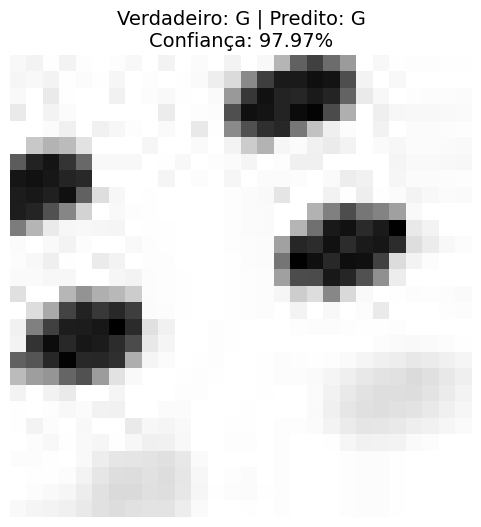


 Resultado da Predição:
  Letra verdadeira: G
  Letra predita: G
  Confiança: 97.97%
  Status: CORRETO


In [30]:
# Lista de classes (A-Z)
CLASSES = [chr(ord('A') + i) for i in range(26)]

# ========================================
# Selecionar uma imagem aleatória
# ========================================

# Pegar o primeiro batch do dataset de teste
for images, labels in test_ds.take(1):
    pass  # Apenas pega o batch e sai do loop

# Sortear um índice aleatório dentro do batch
idx = np.random.randint(0, images.shape[0])

# Extrair a imagem e o label verdadeiro
img = images[idx].numpy()           # Imagem selecionada
true_label = labels[idx].numpy()    # Label verdadeiro (número 0-25)

# Preparar imagem para predição (adicionar dimensão do batch)
img_input = np.expand_dims(img, axis=0)  # Shape: (1, 28, 28, 1)


# Fazer predição

pred = model.predict(img_input, verbose=0)  # Predição (probabilidades)
pred_idx = np.argmax(pred)                  # Índice da classe com maior probabilidade
pred_letra = CLASSES[pred_idx]             # Letra predita
letra_real = CLASSES[true_label]           # Letra verdadeira
confidence = np.max(pred)                   # Confiança da predição]


# Visualizar resultado

plt.figure(figsize=(6, 6))
plt.imshow(img.squeeze(), cmap="gray")
plt.title(
    f"Verdadeiro: {letra_real} | Predito: {pred_letra}\nConfiança: {confidence*100:.2f}%",
    fontsize=14
)
plt.axis("off")
plt.show()

# Mostrar resultado
print(f"\n Resultado da Predição:")
print(f"  Letra verdadeira: {letra_real}")
print(f"  Letra predita: {pred_letra}")
print(f"  Confiança: {confidence*100:.2f}%")
print(f"  Status: {'CORRETO' if pred_letra == letra_real else 'INCORRETO'}")
 # TEXT TO SPEECH (Ler a letra predita)
tts = gTTS(text=pred_letra, lang='pt')
tts.save("voz_letra.mp3")
ipd.display(ipd.Audio("voz_letra.mp3", autoplay=True))

---
## Inferência com Upload de Imagem

Permite fazer upload de uma imagem externa e obter a predição do modelo.

### Requisitos da Imagem:
- Formato: PNG, JPG, JPEG, BMP

### Pré-processamento Aplicado:
1. Conversão para escala de cinza
2. Redimensionamento para 28x28 pixels
3.  Não normalizar manualmente (o modelo já tem camada Rescaling)

Faça upload de uma imagem de caractere Braille:


Saving Captura de tela 2025-12-01 210742.png to Captura de tela 2025-12-01 210742 (1).png

 Arquivo recebido: Captura de tela 2025-12-01 210742 (1).png
  Shape processado: (1, 28, 28, 1)
  Range de valores: [0, 255]

Fazendo predição


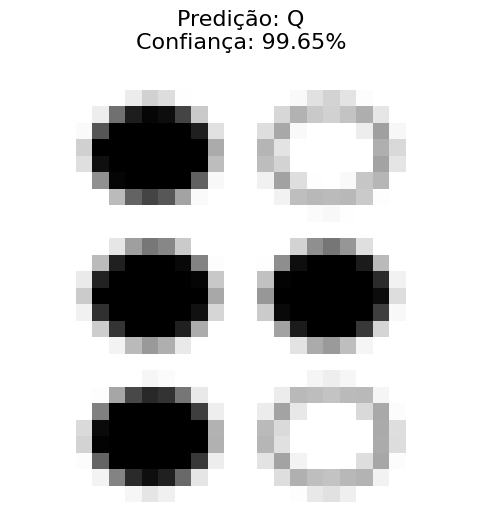

 RESULTADO DA INFERÊNCIA
-------------------------
  Letra predita: Q
  Confiança: 99.65%
-------------------------



Top 3 Predições:
  1. Q: 99.65% ███████████████████
  2. R:  0.35% 
  3. V:  0.00% 


In [17]:
from google.colab import files
from PIL import Image

# Lista de classes (A-Z)
CLASSES = [chr(ord('A') + i) for i in range(26)]

#  Upload da Imagem

print("Faça upload de uma imagem de caractere Braille:")
uploaded = files.upload()

if uploaded:
    nomearquivo = list(uploaded.keys())[0]
    print(f"\n Arquivo recebido: {nomearquivo}")

    # Pré-processamento da Imagem

    # Carregar imagem e converter para escala de cinza
    img = Image.open(nomearquivo).convert("L")

    # Redimensionar para 28x28 pixels (tamanho usado no treinamento)
    img = img.resize((28, 28))

    # Converter para array NumPy
    img_array = np.array(img)

    # Adicionar dimensões para batch e canal
    # Shape final: (1, 28, 28, 1) = (batch, altura, largura, canais)
    img_input = np.expand_dims(img_array, axis=(0, -1))

    print(f"  Shape processado: {img_input.shape}")
    print(f"  Range de valores: [{img_input.min()}, {img_input.max()}]")

    # Predição

    print("\nFazendo predição")
    pred = model.predict(img_input, verbose=0)
    pred_idx = np.argmax(pred)              # Índice da classe predita
    pred_letra = CLASSES[pred_idx]         # Letra predita
    confianca = pred[0][pred_idx]          # Confiança da predição

    # Visualização do Resultado

    plt.figure(figsize=(8, 6))
    plt.imshow(img_array, cmap="gray")
    plt.title(f"Predição: {pred_letra}\nConfiança: {confianca*100:.2f}%", fontsize=16)
    plt.axis("off")
    plt.show()

    # Mostrar resultado principal
    print(f" RESULTADO DA INFERÊNCIA")
    print(f"{'-'*25}")
    print(f"  Letra predita: {pred_letra}")
    print(f"  Confiança: {confianca*100:.2f}%")
    print(f"{'-'*25}")
    # TEXT TO SPEECH (Ler a letra predita)
    tts = gTTS(text=pred_letra, lang='pt')
    tts.save("voz_letra.mp3")
    ipd.display(ipd.Audio("voz_letra.mp3", autoplay=True))


    # 5. Top-3 Predições (para análise)

    print(f"\nTop 3 Predições:")
    top3_idx = np.argsort(pred[0])[-3:][::-1]  # 3 maiores probabilidades
    for i, idx in enumerate(top3_idx, 1):
        letra = CLASSES[idx]
        prob = pred[0][idx] * 100
        barra = "█" * int(prob / 5)  # Barra visual
        print(f"  {i}. {letra}: {prob:5.2f}% {barra}")

    # Alertas de baixa confiança
    if confianca < 0.5:
        print(f"\n AVISO: Confiança muito baixa (<50%)")
        print(f"   Possíveis causas:")
        print(f"   - Imagem com qualidade ruim")
        print(f"   - Caractere diferente do dataset de treino")
        print(f"   - Imagem muito diferente (fundo, iluminação, etc)")

else:
    print("\n Nenhum arquivo foi enviado.")

---
## Inferência com Foto registrada pela camera do usuario

Permite tirar uma foto e enviar para o modelo fazer a inferencia

### Pré-processamento Aplicado:
1. Conversão para escala de cinza
2. Redimensionamento para 28x28 pixels
3.  Não normalizar manualmente (o modelo já tem camada Rescaling)

In [13]:
from IPython.display import display, Javascript, Image as IPImage
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import io

def take_photo(filename='photo.jpg', quality=0.9):
    js = Javascript('''
        async function main(quality) {
            const div = document.createElement('div');
            const video = document.createElement('video');
            const button = document.createElement('button');

            div.style = 'display: flex; flex-direction: column; align-items: center;';
            button.textContent = '📸 Capturar Foto';
            button.style = 'margin-top: 10px; padding: 10px 20px; font-size: 16px;';

            div.appendChild(video);
            div.appendChild(button);
            document.body.appendChild(div);

            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await video.play();

            // Espera clique do usuário
            await new Promise(resolve => button.onclick = resolve);

            // Faz captura do frame
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);

            // Para câmera
            stream.getVideoTracks()[0].stop();

            // Remove elementos
            div.remove();

            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)

    data = eval_js(f'main({quality})')
    binary = b64decode(data.split(',')[1])

    with open(filename, 'wb') as f:
        f.write(binary)

    return filename


<IPython.core.display.Javascript object>

 Imagem capturada: captured_image.jpg
Shape: (1, 28, 28, 1)
Range: [3, 226]


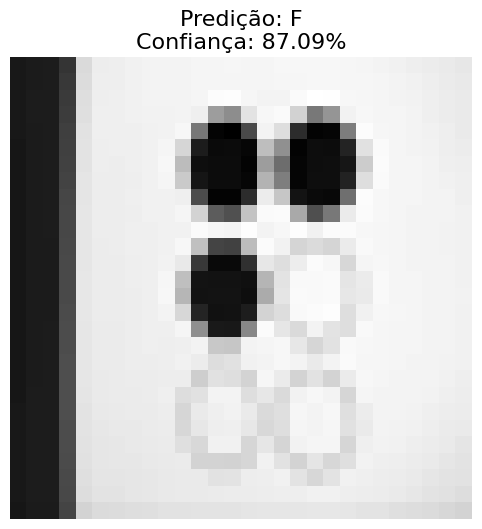


RESULTADO
------------------------------
Letra predita: F
Confiança: 87.09%
------------------------------


In [20]:


try:
    filename = take_photo('captured_image.jpg')
    print(f" Imagem capturada: {filename}")

    # Pré-processamento
    img = Image.open(filename).convert("L")
    img = img.resize((28, 28))
    img_array = np.array(img)
    img_input = np.expand_dims(img_array, axis=(0, -1))

    print(f"Shape: {img_input.shape}")
    print(f"Range: [{img_input.min()}, {img_input.max()}]")

    # Predição
    pred = model.predict(img_input, verbose=0)
    pred_idx = np.argmax(pred)
    pred_letra = CLASSES[pred_idx]
    confianca = pred[0][pred_idx]

    # Visualização
    plt.figure(figsize=(8, 6))
    plt.imshow(img_array, cmap="gray")
    plt.title(f"Predição: {pred_letra}\nConfiança: {confianca*100:.2f}%", fontsize=16)
    plt.axis("off")
    plt.show()

    print("\nRESULTADO")
    print("-"*30)
    print(f"Letra predita: {pred_letra}")
    print(f"Confiança: {confianca*100:.2f}%")
    print("-"*30)

    # TEXT TO SPEECH (Ler a letra predita)
    tts = gTTS(text=pred_letra, lang='pt')
    tts.save("voz_letra.mp3")
    ipd.display(ipd.Audio("voz_letra.mp3", autoplay=True))


except Exception as e:
    print("Erro:", e)
    print("Problema ao acessar a câmera no Colab.")


---
## Matriz Confusão

Contrói a matriz confusão do modelo treinado

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


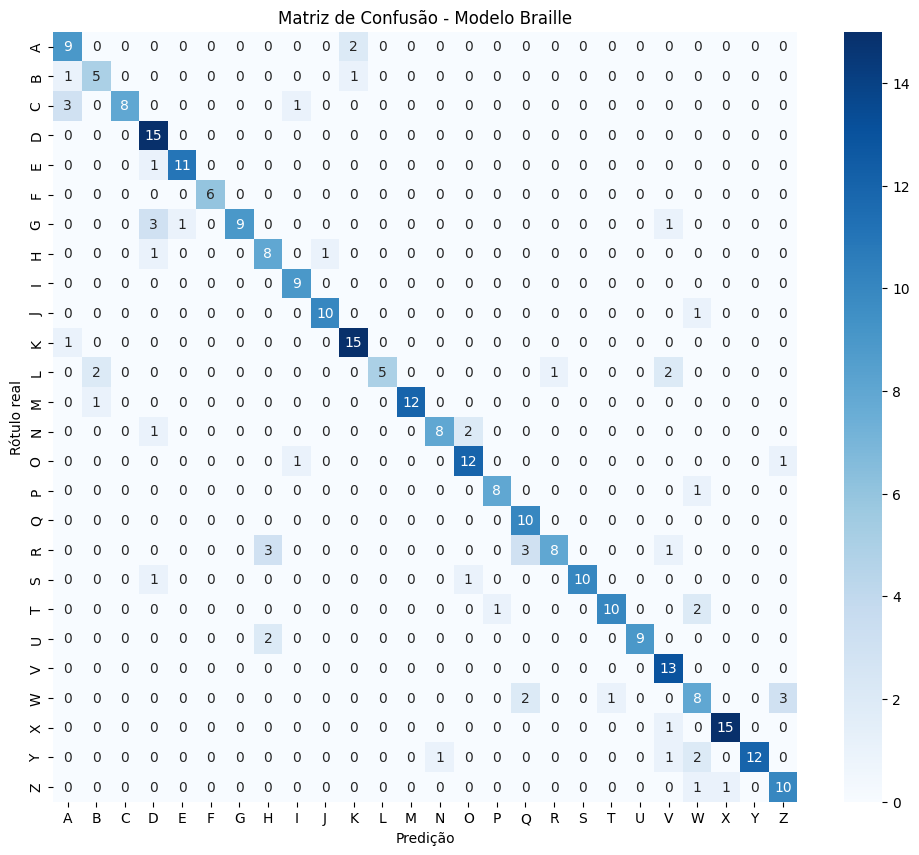

In [15]:
# Extrair imagens e rótulos do test_ds
all_images = []
all_labels = []

for images, labels in test_ds:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

X_test = np.concatenate(all_images, axis=0)
y_true_labels = np.concatenate(all_labels, axis=0)

# Gerar predições do modelo
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=CLASSES,
            yticklabels=CLASSES)

plt.xlabel("Predição")
plt.ylabel("Rótulo real")
plt.title("Matriz de Confusão - Modelo Braille")
plt.show()